
Оценка модели на валидационных данных...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1622.9±234.2 MB/s, size: 73.0 KB)
val: Scanning /content/final_vest_dataset/labels/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 34/34 66.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.2it/s 12.3s
                   all         34        197      0.594       0.67      0.622      0.416
                person         34        118       0.84      0.847       0.89      0.606
         unzipped_vest         13         13      0.385      0.538      0.409       0.25
           zipped_vest         21         32      0.559       0.91      0.714      0.487
          unknown_vest         18         34       0.59      0.382      0.474      0.322
Speed: 12.8ms preprocess, 328.4ms inference, 0.0ms loss, 8.8ms postprocess per 

,№,Изображение,Люди,Жилеты,Расстегнутые,Застегнутые,Безопасность
0,1,00504_jpg.rf.b2286ff900ffe95d399fa49e9baf3377.jpg,7,5,0,5,[!]
1,2,02044_jpg.rf.033ed2e37c5e42e73531a16c42bee39a.jpg,5,4,1,0,[!]
2,3,ppe_0859_jpg.rf.79ebd9e6ff996823f480a41281459201.jpg,3,1,0,1,[!]
3,4,01110_jpg.rf.23fd56304ee6f8730c1df5a340710a86.jpg,3,3,0,3,[OK]
4,5,01261_jpg.rf.252a19eaf4abd176877d4b4d7ab5d021.jpg,3,3,1,2,[OK]
5,6,helmet_jacket_07369_jpg.rf.8b7222a7bfed218dc89293aab0495a8a.jpg,3,3,1,2,[OK]
6,7,pos_1738_jpg.rf.b71128d6951a76f29093a4fe7e05c3bd.jpg,4,3,1,2,[!]
7,8,ppe_0375_jpg.rf.f2b39d5782ad46f061efc157f2fc6737.jpg,5,5,0,5,[OK]
8,9,helmet_jacket_08137_jpg.rf.f226dc8bd01500a565a8679f6206d9cd.jpg,5,6,2,3,[OK]
9,10,r389_jpg.rf.680bc169b82d7756bb3913197988cfe5.jpg,1,1,0,1,[OK]



СВОДНАЯ СТАТИСТИКА ПО ЖИЛЕТАМ
Всего проанализировано изображений: 34
Безопасных ситуаций: 18 (52.9%)
Нарушений безопасности: 16 (47.1%)
Изображений без данных: 0 (0.0%)
Общее количество обнаруженных людей: 118
Общее количество всех жилетов: 89
Общее количество расстегнутых жилетов: 17
Общее количество застегнутых жилетов: 51
Общее количество жилетов неизвестного статуса: 21
Общее количество нарушений: 35

ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ ОБНАРУЖЕНИЯ
НАРУШЕНИЕ: 00504_jpg.rf.b2286ff900ffe95d399fa49e9baf3377.jpg - Люди: 7, Жилеты: 5, Нарушения: 2
НАРУШЕНИЕ: ppe_0859_jpg.rf.79ebd9e6ff996823f480a41281459201.jpg - Люди: 3, Жилеты: 1, Нарушения: 2
БЕЗОПАСНО: 01110_jpg.rf.23fd56304ee6f8730c1df5a340710a86.jpg - Люди: 3, Жилеты: 3, Нарушения: 0
БЕЗОПАСНО: helmet_jacket_07369_jpg.rf.8b7222a7bfed218dc89293aab0495a8a.jpg - Люди: 3, Жилеты: 3, Нарушения: 0


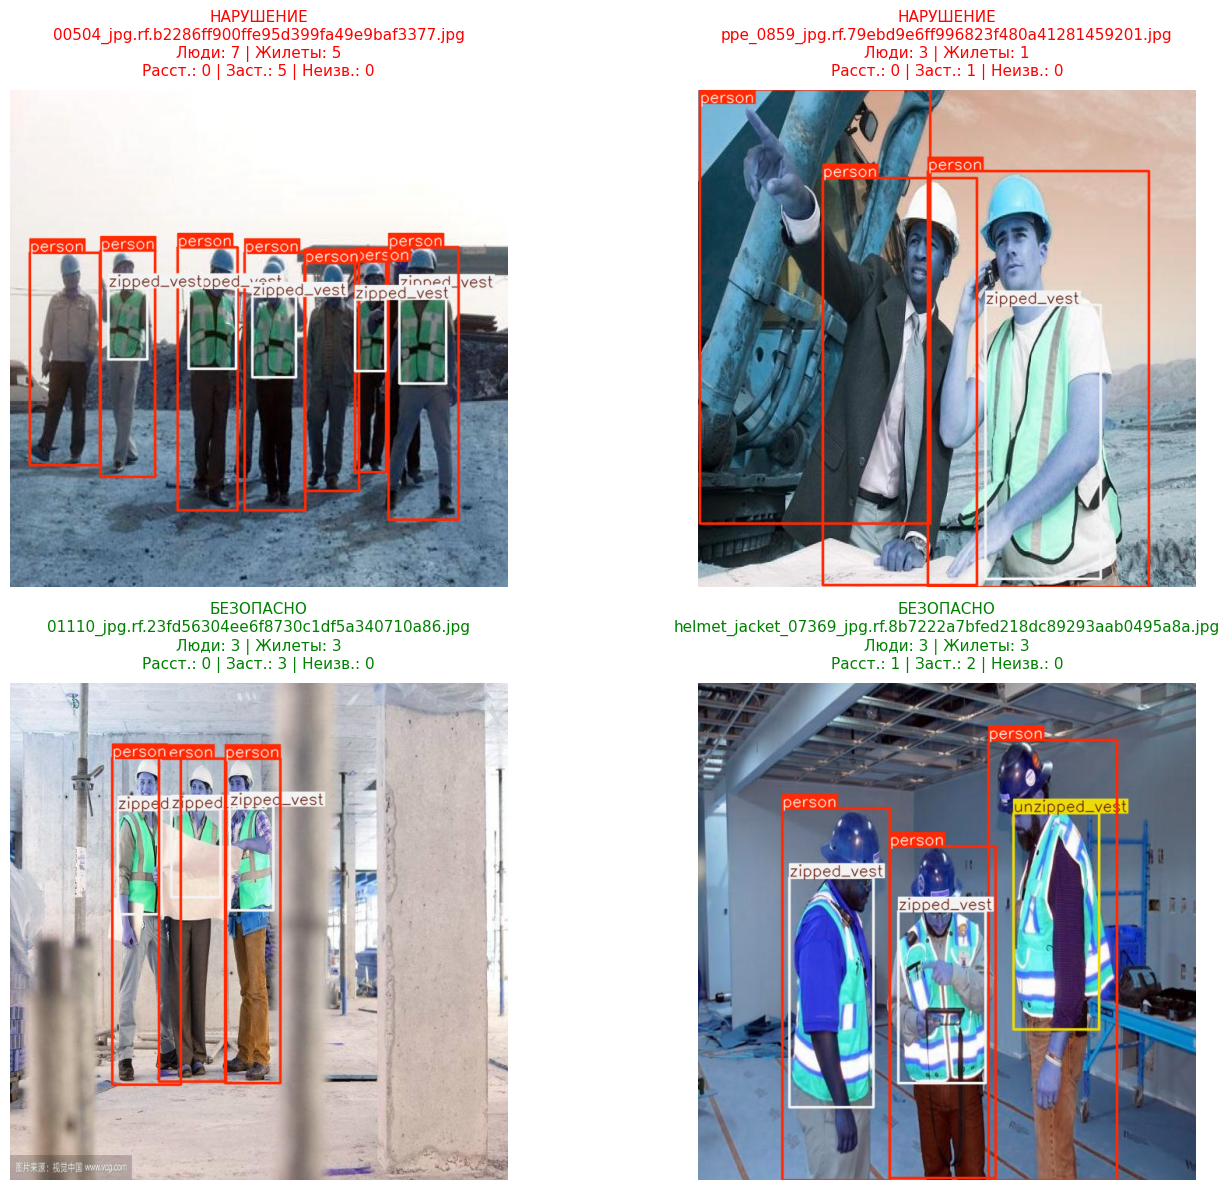

In [ ]:
print("\nОценка модели на валидационных данных...")

metrics = best_model.val(
    data=yaml_path,
    device='cpu'
)

print("\n" + "="*50)
print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ ДЛЯ ЖИЛЕТОВ")
print("="*50)
print(f"mAP@0.5: {metrics.box.map:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map50:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print("="*50)

print("\n" + "="*60)
print("АНАЛИЗ ВАЛИДАЦИОННЫХ ИЗОБРАЖЕНИЙ ДЛЯ ЖИЛЕТОВ")
print("="*60)

val_images_dir = "/content/final_vest_dataset/images/val"


def simple_supervision_visualization(image_path, model, conf_threshold=0.15):
    """Визуализирует обнаружения на изображении с цветовыми рамками"""
    try:

        results = model.predict(
            source=image_path,
            conf=conf_threshold,
            iou=0.4,
            device='cpu',
            verbose=False
        )

        plotted_image = results[0].plot(
            line_width=2,
            font_size=14,
            conf=False
        )

        return plotted_image, results[0]

    except Exception as e:
        print(f"Ошибка при визуализации {image_path}: {e}")
        return None, None

if os.path.exists(val_images_dir):
    val_images = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Найдено валидационных изображений: {len(val_images)}")

    results_data = []

    for i, img_name in enumerate(val_images):
        img_path = os.path.join(val_images_dir, img_name)

        results = best_model.predict(
            source=img_path,
            conf=0.15,
            iou=0.4,
            device='cpu',
            verbose=False
        )

        persons_found = 0
        unzipped_vests = 0
        zipped_vests = 0
        unknown_vests = 0

        for r in results:
            boxes = r.boxes
            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    cls = int(box.cls)

                    if cls == 0:
                        persons_found += 1
                    elif cls == 1:
                        unzipped_vests += 1
                    elif cls == 2:
                        zipped_vests += 1
                    elif cls == 3:
                        unknown_vests += 1


        total_vests = unzipped_vests + zipped_vests + unknown_vests

        if persons_found > total_vests:
            safety_status = "НАРУШЕНИЕ"
            safety_symbol = "[!]"
            safety_violations = persons_found - total_vests
        elif persons_found == 0 and total_vests == 0:
            safety_status = "НЕТ ДАННЫХ"
            safety_symbol = "[?]"
            safety_violations = 0
        else:
            safety_status = "БЕЗОПАСНО"
            safety_symbol = "[OK]"
            safety_violations = 0

        results_data.append({
            '№': i + 1,
            'Изображение': img_name,
            'Люди': persons_found,
            'Расстегнутые': unzipped_vests,
            'Застегнутые': zipped_vests,
            'Неизвестно': unknown_vests,
            'Всего_жилетов': total_vests,
            'Безопасность': safety_status,
            'Безопасность_символ': safety_symbol,
            'Нарушения': safety_violations
        })

        if (i + 1) % 5 == 0 or (i + 1) == len(val_images):
            print(f"Обработано {i + 1}/{len(val_images)} изображений...")

    df = pd.DataFrame(results_data)

    print("\n" + "="*80)
    print("ТАБЛИЦА РЕЗУЛЬТАТОВ АНАЛИЗА ЖИЛЕТОВ")
    print("="*80)


    styled_df = df[['№', 'Изображение', 'Люди', 'Всего_жилетов', 'Расстегнутые', 'Застегнутые', 'Безопасность_символ']]\
        .rename(columns={
            'Всего_жилетов': 'Жилеты',
            'Безопасность_символ': 'Безопасность'
        })\
        .style\
        .applymap(lambda x: 'background-color: #FFB6C1' if x == '[!]' else '', subset=['Безопасность'])\
        .applymap(lambda x: 'background-color: #90EE90' if x == '[OK]' else '', subset=['Безопасность'])\
        .applymap(lambda x: 'background-color: #E6E6FA' if x == '[?]' else '', subset=['Безопасность'])\
        .set_properties(**{'text-align': 'center'})

    display(styled_df)

    print("\n" + "="*80)
    print("СВОДНАЯ СТАТИСТИКА ПО ЖИЛЕТАМ")
    print("="*80)

    total_images = len(df)
    violations = len(df[df['Безопасность'] == 'НАРУШЕНИЕ'])
    safe_images = len(df[df['Безопасность'] == 'БЕЗОПАСНО'])
    no_data = len(df[df['Безопасность'] == 'НЕТ ДАННЫХ'])

    print(f"Всего проанализировано изображений: {total_images}")
    print(f"Безопасных ситуаций: {safe_images} ({safe_images/total_images*100:.1f}%)")
    print(f"Нарушений безопасности: {violations} ({violations/total_images*100:.1f}%)")
    print(f"Изображений без данных: {no_data} ({no_data/total_images*100:.1f}%)")
    print(f"Общее количество обнаруженных людей: {df['Люди'].sum()}")
    print(f"Общее количество всех жилетов: {df['Всего_жилетов'].sum()}")
    print(f"Общее количество расстегнутых жилетов: {df['Расстегнутые'].sum()}")
    print(f"Общее количество застегнутых жилетов: {df['Застегнутые'].sum()}")
    print(f"Общее количество жилетов неизвестного статуса: {df['Неизвестно'].sum()}")
    print(f"Общее количество нарушений: {df['Нарушения'].sum()}")


    print("\n" + "="*80)
    print("ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ ОБНАРУЖЕНИЯ")
    print("="*80)


    violation_examples = []
    safe_examples = []


    for _, row in df[df['Нарушения'] > 0].iterrows():
        violation_examples.append((
            row['Изображение'],
            row['Люди'],
            row['Всего_жилетов'],
            row['Расстегнутые'],
            row['Застегнутые'],
            row['Неизвестно'],
            'НАРУШЕНИЕ',
            row['Нарушения']
        ))

    for _, row in df[df['Безопасность'] == 'БЕЗОПАСНО'].iterrows():
        safe_examples.append((
            row['Изображение'],
            row['Люди'],
            row['Всего_жилетов'],
            row['Расстегнутые'],
            row['Застегнутые'],
            row['Неизвестно'],
            'БЕЗОПАСНО',
            0
        ))



    selected_violations = filtered_violations[:2]
    selected_safe = filtered_safe[:2]

    selected_images = selected_violations + selected_safe

    if selected_images:

        n_rows = 2
        n_cols = 2
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = np.array([axes])
        elif n_cols == 1:
            axes = np.array([[ax] for ax in axes])

        for i, (img_name, persons, total_vests, unzipped, zipped, unknown, status, violations_count) in enumerate(selected_images):
            if i >= n_rows * n_cols:
                break

            img_path = os.path.join(val_images_dir, img_name)


            annotated_image, detections = simple_supervision_visualization(img_path, best_model)


            row_idx = i // n_cols
            col_idx = i % n_cols


            axes[row_idx, col_idx].imshow(annotated_image)


            title_color = 'red' if status == "НАРУШЕНИЕ" else 'green'

            axes[row_idx, col_idx].set_title(f'{status}\n{img_name}\nЛюди: {persons} | Жилеты: {total_vests}\nРасст.: {unzipped} | Заст.: {zipped} | Неизв.: {unknown}',
                             fontsize=11, color=title_color, pad=10)
            axes[row_idx, col_idx].axis('off')

            print(f"{status}: {img_name} - Люди: {persons}, Жилеты: {total_vests}, Нарушения: {violations_count}")

        total_plots = n_rows * n_cols
        if len(selected_images) < total_plots:
            for i in range(len(selected_images), total_plots):
                row_idx = i // n_cols
                col_idx = i % n_cols
                axes[row_idx, col_idx].axis('off')

        plt.tight_layout()
        plt.show()